

# GLM Analysis (Measured)

In this example we analyse data from a real multichannel
functional near-infrared spectroscopy (fNIRS)
experiment (see `tut-fnirs-hrf-sim` for a simplified simulated
analysis). The experiment consists of three conditions:

1. tapping with the left hand,
2. tapping with the right hand,
3. a control condition where the participant does nothing.

We use a GLM analysis to examine the neural activity associated with
the different tapping conditions.
An alternative epoching style analysis on the same data can be
viewed in the
`waveform analysis example <tut-fnirs-processing>`.
See
[Luke et al (2021)](https://www.spiedigitallibrary.org/journals/neurophotonics/volume-8/issue-2/025008/Analysis-methods-for-measuring-passive-auditory-fNIRS-responses-generated-by/10.1117/1.NPh.8.2.025008.short)_
for a comparison of the epoching and GLM approaches.

This GLM analysis is a wrapper over the excellent
[Nilearn GLM](http://nilearn.github.io/modules/reference.html#module-nilearn.glm)_.


In [3]:
# sphinx_gallery_thumbnail_number = 9

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

import os

import matplotlib.pyplot as plt
import mne
import numpy as np
from nilearn.plotting import plot_design_matrix

import mne_nirs
from mne_nirs.channels import get_long_channels, get_short_channels, picks_pair_to_idx
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm

## Import raw NIRS data

First we import the motor tapping data, these data are also
described and used in the
`MNE fNIRS tutorial <mne:tut-fnirs-processing>`

After reading the data we resample down to 1Hz
to meet github memory constraints.

<div class="alert alert-info"><h4>Note</h4><p>Optodes were placed over the motor cortex using the standard NIRX motor
   montage, but with 8 short channels added (see their web page for details).
   To view the sensor locations run ``raw_intensity.plot_sensors()``.
   A sound was presented to indicate which hand the participant should tap.
   Participants tapped their thumb to their fingers for 5s.
   Conditions were presented in a random order with a randomised inter
   stimulus interval.</p></div>



In [10]:
fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_raw_dir = os.path.join(fnirs_data_folder, "Participant-1")
raw_intensity = mne.io.read_raw_nirx(fnirs_raw_dir).load_data()
raw_intensity.resample(0.7)

Loading C:\Users\bede\mne_data\MNE-fNIRS-motor-data\Participant-1


Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


<RawNIRX | Participant-1, 56 x 2082 (2974.3 s), ~969 KiB, data loaded>

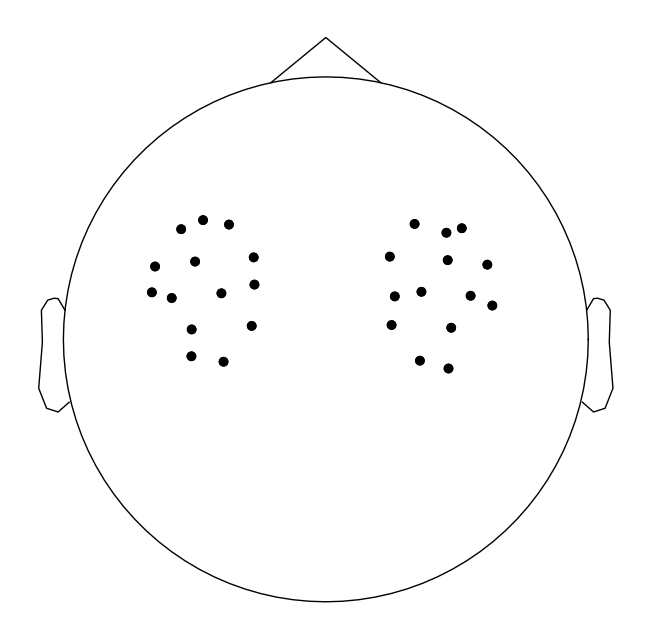

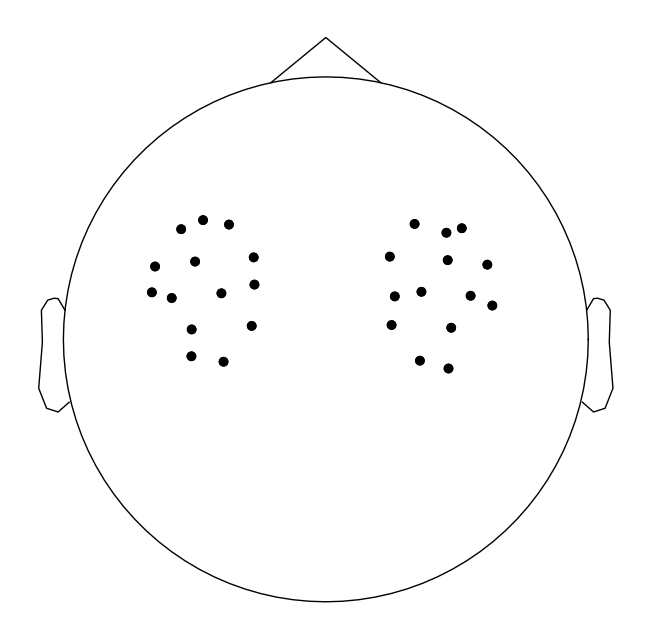

In [11]:
raw_intensity.plot_sensors()

## Clean up annotations before analysis

Next we update the annotations by assigning names to each trigger ID.
Then we crop the recording to the section containing our
experimental conditions.

Because of limitations with ``nilearn``, we use ``'_'`` to separate conditions
rather than the standard ``'/'``.



In [12]:
event_list = raw_intensity.annotations.description
event_list

array(['15.0', '1.0', '1.0', '3.0', '3.0', '1.0', '2.0', '2.0', '1.0',
       '3.0', '3.0', '2.0', '2.0', '2.0', '3.0', '2.0', '1.0', '2.0',
       '3.0', '1.0', '2.0', '3.0', '2.0', '1.0', '1.0', '2.0', '1.0',
       '2.0', '1.0', '3.0', '2.0', '3.0', '1.0', '3.0', '2.0', '3.0',
       '3.0', '2.0', '1.0', '3.0', '2.0', '2.0', '3.0', '1.0', '3.0',
       '3.0', '2.0', '3.0', '2.0', '3.0', '2.0', '1.0', '3.0', '1.0',
       '1.0', '2.0', '3.0', '2.0', '1.0', '2.0', '1.0', '3.0', '3.0',
       '3.0', '2.0', '3.0', '1.0', '1.0', '3.0', '3.0', '1.0', '1.0',
       '3.0', '3.0', '1.0', '1.0', '1.0', '2.0', '2.0', '1.0', '2.0',
       '2.0', '3.0', '1.0', '1.0', '2.0', '1.0', '2.0', '1.0', '3.0',
       '2.0', '15.0'], dtype='<U4')

In [13]:
raw_intensity.annotations.rename(
    {"1.0": "Control", "2.0": "Tapping_Left", "3.0": "Tapping_Right"}
)
raw_intensity.annotations.delete(raw_intensity.annotations.description == "15.0")
raw_intensity.annotations.set_durations(5)
#raw.annotations.delete(np.where(eventlist =='11.0')) # exp start
raw_intensity.annotations.description

array(['Control', 'Control', 'Tapping_Right', 'Tapping_Right', 'Control',
       'Tapping_Left', 'Tapping_Left', 'Control', 'Tapping_Right',
       'Tapping_Right', 'Tapping_Left', 'Tapping_Left', 'Tapping_Left',
       'Tapping_Right', 'Tapping_Left', 'Control', 'Tapping_Left',
       'Tapping_Right', 'Control', 'Tapping_Left', 'Tapping_Right',
       'Tapping_Left', 'Control', 'Control', 'Tapping_Left', 'Control',
       'Tapping_Left', 'Control', 'Tapping_Right', 'Tapping_Left',
       'Tapping_Right', 'Control', 'Tapping_Right', 'Tapping_Left',
       'Tapping_Right', 'Tapping_Right', 'Tapping_Left', 'Control',
       'Tapping_Right', 'Tapping_Left', 'Tapping_Left', 'Tapping_Right',
       'Control', 'Tapping_Right', 'Tapping_Right', 'Tapping_Left',
       'Tapping_Right', 'Tapping_Left', 'Tapping_Right', 'Tapping_Left',
       'Control', 'Tapping_Right', 'Control', 'Control', 'Tapping_Left',
       'Tapping_Right', 'Tapping_Left', 'Control', 'Tapping_Left',
       'Control', 'Tapp

## Preprocess NIRS data
Next we convert the raw data to haemoglobin concentration.



In [14]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)

.. sidebar:: Relevant literature

   Tachtsidis, Ilias, and Felix Scholkmann. "False positives and false
   negatives in functional near-infrared spectroscopy: issues, challenges,
   and the way forward." Neurophotonics 3.3 (2016): 031405.

We then split the data in to
short channels which predominantly contain systemic responses and
long channels which have both neural and systemic contributions.



In [15]:
short_chs = get_short_channels(raw_haemo)
raw_haemo = get_long_channels(raw_haemo)

## View experiment events

Next we examine the timing and order of events in this experiment.
There are several options for how to view event information.
The first option is to use MNE's plot events command.
Here each dot represents when an event started.
We observe that the order of conditions was randomised and the time between
events is also randomised.



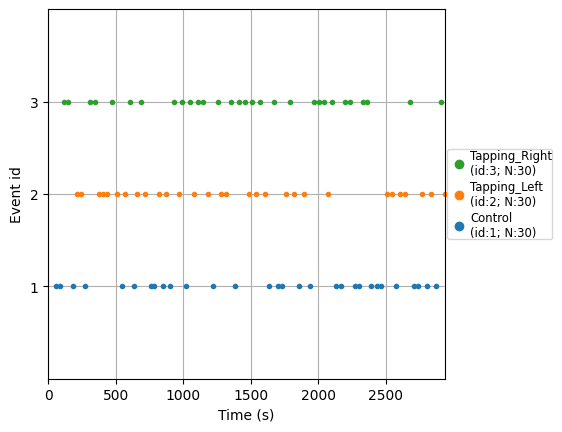

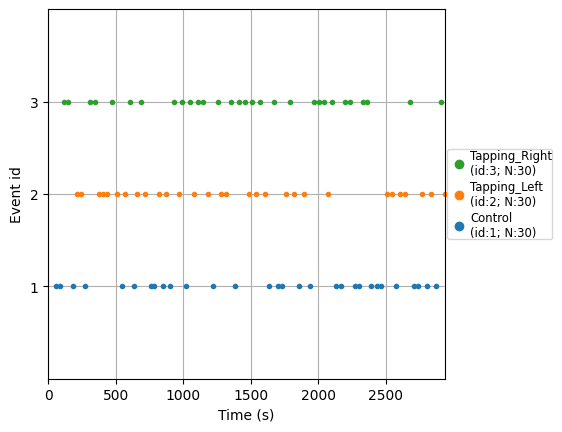

In [16]:
events, event_dict = mne.events_from_annotations(raw_haemo, verbose=False)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_haemo.info["sfreq"])

The previous plot did not illustrate the duration that an event lasted for.
Alternatively, we can view the experiment using a boxcar plot, where the
line is raised for the duration of the stimulus/condition.



Used Annotations descriptions: [np.str_('Control'), np.str_('Tapping_Left'), np.str_('Tapping_Right')]


Text(0.5, 0, 'Time (s)')

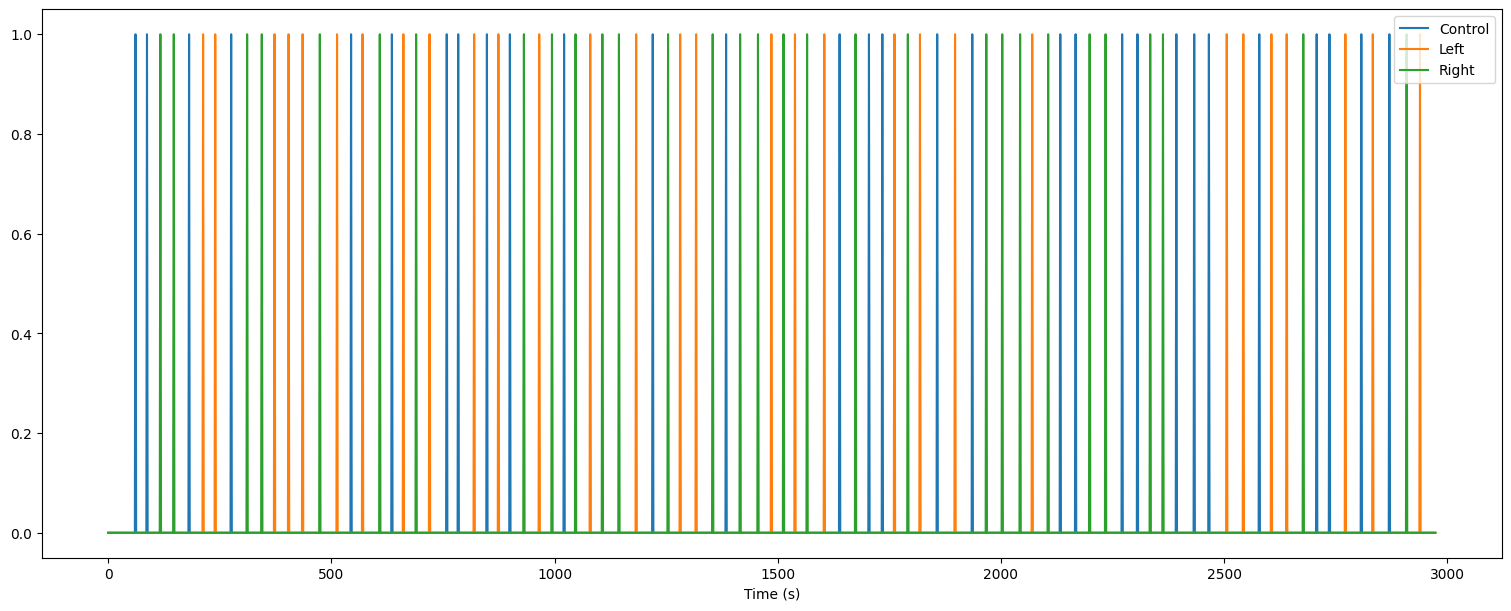

In [20]:
s = mne_nirs.experimental_design.create_boxcar(raw_haemo)
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)
ax.plot(raw_haemo.times, s)
ax.legend(["Control", "Left", "Right"], loc="upper right")
ax.set_xlabel("Time (s)")

## Create design matrix

.. sidebar:: Relevant literature

   For further discussion on design matrices see
   the Nilearn examples. Specifically the
   [first level model example](http://nilearn.github.io/auto_examples/04_glm_first_level/plot_first_level_details.html)_.

Next we create a model to fit our data to.
The model consists of various components to model different things we assume
contribute to the measured signal.
We model the expected neural response for each experimental condition
using the SPM haemodynamic response
function (HRF) combined with the known stimulus event times and durations
(as described above).
We also include a cosine drift model with components up to the high pass
parameter value. See the nilearn documentation for recommendations on setting
these values. In short, they suggest "The cutoff period (1/high_pass) should be
set as the longest period between two trials of the same condition multiplied by 2.
For instance, if the longest period is 32s, the high_pass frequency shall be
1/64 Hz ~ 0.016 Hz".



In [42]:
design_matrix = make_first_level_design_matrix(
    raw_haemo,
    drift_model="cosine",
    high_pass=0.005,  # Must be specified per experiment
    hrf_model="spm",
    stim_dur=5.0,
)

In [ ]:
#print(raw_intensity.annotations.description)
tap_right_events = np.where(raw_intensity.annotations.description=='Tapping_Right')
tap_right_longest_period = max(np.diff(raw_haemo.annotations.onset[tap_right_events])) # wrong -> use offset to onset? 
                     
print(f"Longest period between two trials of the same condition: {tap_right_longest_period} s")
print(f"High-pass frequency should be: {1/(2*tap_right_longest_period)} Hz")

Longest period between two trials of the same condition: 315.2640000000001 s
High-pass frequency should be: 0.00158597239139261 Hz


We also add the mean of the short channels to the design matrix.
In theory these channels contain only systemic components, so including
them in the design matrix allows us to estimate the neural component
related to each experimental condition
uncontaminated by systemic effects.



In [50]:
design_matrix["ShortHbO"] = np.mean(
    short_chs.copy().pick(picks="hbo").get_data(), axis=0 # average across channels for each time point
)

# print(np.mean(short_chs.copy().pick(picks="hbo").get_data(), axis=1).shape)
# print(design_matrix["ShortHbO"].shape)
# print(short_chs.copy().pick(picks="S1_D9 hbo").get_data())

design_matrix["ShortHbR"] = np.mean(
    short_chs.copy().pick(picks="hbr").get_data(), axis=0
)

And we display a summary of the design matrix
using standard Nilearn reporting functions.
The first three columns represent the SPM HRF convolved with our stimulus
event information.
The next columns illustrate the drift and constant components.
The last columns illustrate the short channel signals.



C:\Users\bede\AppData\Local\Temp\ipykernel_7964\1044303472.py:2: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  fig = plot_design_matrix(design_matrix, ax=ax1)


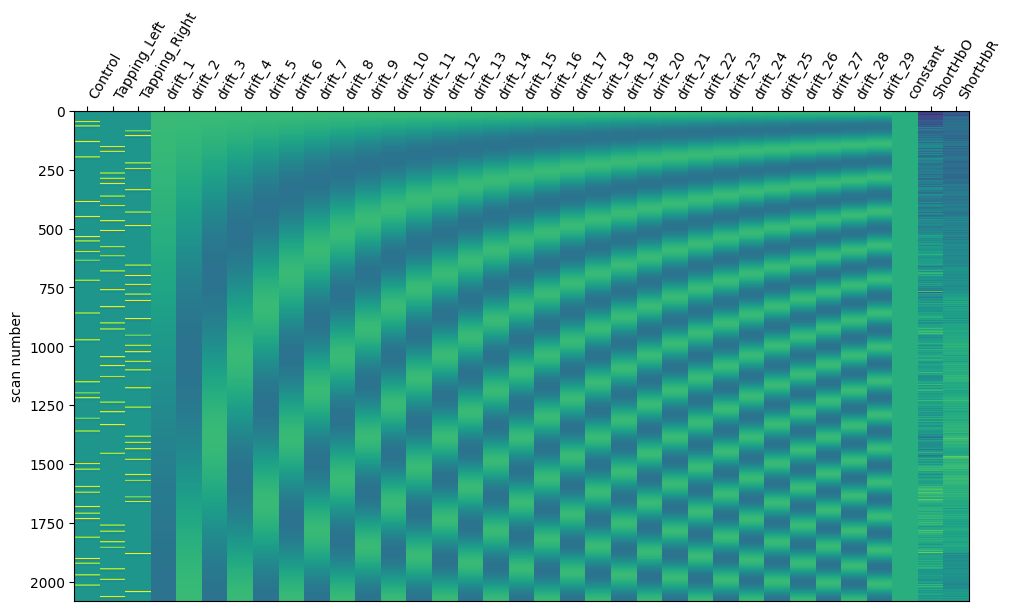

In [51]:
fig, ax1 = plt.subplots(figsize=(10, 6), constrained_layout=True)
fig = plot_design_matrix(design_matrix, ax=ax1)

## Examine expected response

The matrices above can be a bit abstract as they encompase multiple
conditions and regressors.
Instead we can examine a single condition.
Here we observe the boxcar function for a single condition,
this illustrates when the stimulus was active.
We also view the expected neural response using the HRF specified above,
we observe that each time a stimulus is presented there is an expected
brain response that lags the stimulus onset and consists of a large positive
component followed by an undershoot.

In this example the second trigger (index 1) corresponds to the ``Tapping/Left``
condition in the design matrix, so we plot those below. In your data the mapping
may be different, so you may need to alter either the ``s`` index or condition
name. Note however, that this is just for visualisation and does not affect
the results below.



Used Annotations descriptions: [np.str_('Control'), np.str_('Tapping_Left'), np.str_('Tapping_Right')]


[(180.0, 300.0), Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Amplitude')]

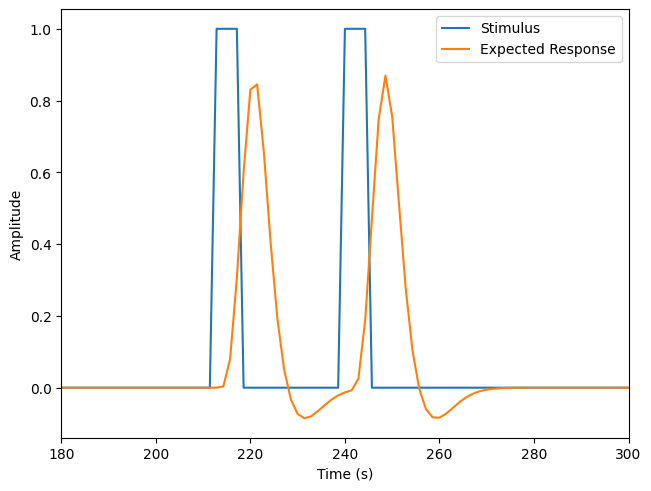

In [52]:
fig, ax = plt.subplots(constrained_layout=True)
s = mne_nirs.experimental_design.create_boxcar(raw_intensity, stim_dur=5.0)
ax.plot(raw_intensity.times, s[:, 1])
ax.plot(design_matrix["Tapping_Left"])
ax.legend(["Stimulus", "Expected Response"])
ax.set(xlim=(180, 300), xlabel="Time (s)", ylabel="Amplitude")

## Fit GLM to subset of data and estimate response for each experimental condition

.. sidebar:: Relevant literature

   Huppert TJ. Commentary on the statistical properties of noise and its
   implication on general linear models in functional near-infrared
   spectroscopy. Neurophotonics. 2016;3(1)

We run a GLM fit for the data and experiment matrix.
First we analyse just the first two channels which correspond to HbO and HbR
of a single source detector pair.



In [63]:
data_subset = raw_haemo.copy().pick(picks=range(2))
glm_est = run_glm(data_subset, design_matrix)

This returns a GLM regression estimate for each channel.
This data is stored in a dedicated type.
You can view an overview of the estimates by addressing the variable:



In [64]:
glm_est

GLM Results for 2 channels

As with other MNE types you can use the `pick` function.
To query the mean square error of a single channel you would call.

Note: as we wish to retain both channels for further the analysis below,
we operate on a copy to demonstrate this channel picking functionality.



In [65]:
glm_est.copy().pick("S1_D1 hbr")

GLM Results for 1 channels

Underlying the data for each channel is a standard
[Nilearn RegressionResults object](https://nilearn.github.io/modules/generated/nilearn.glm.RegressionResults.html)
object. These objects are rich with information that can be requested
from the object, for example to determine the mean square error of the
estimates for two channels you would call:



In [66]:
glm_est.MSE()

[np.float64(3.635950128126064e-11), np.float64(9.48201077576093e-12)]

And we can chain the methods to quickly access required details.
For example, to determine the MSE for channel `S1` `D1` for the hbr type
you would call:



In [67]:
glm_est.copy().pick("S1_D1 hbr").MSE()

[np.float64(9.48201077576093e-12)]

Due to the richness of the objects we provide a function to
extract commonly used information and put it in a convenient dataframe/table.
Below this is demonstrated and then we just display the first 9 rows of the
table which correspond to the 9 components of the design matrix for the
first channel.



In [68]:
glm_est.to_dataframe().head(9)

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
0,Control,35.0,3.635950e-11,5.703922e-01,1.271854e-06,0.572874,7.286122e-07,1,1,hbo,False,S1_D1 hbo
1,ShortHbO,35.0,3.635950e-11,5.988346e-39,1.253564e-02,68.802806,8.624875e-01,1,1,hbo,True,S1_D1 hbo
2,ShortHbR,35.0,3.635950e-11,2.051290e-19,7.976514e-02,-18.187656,-1.450741e+00,1,1,hbo,True,S1_D1 hbo
3,Tapping_Left,35.0,3.635950e-11,8.464418e-06,1.289978e-06,5.211297,6.722461e-06,1,1,hbo,True,S1_D1 hbo
4,Tapping_Right,35.0,3.635950e-11,7.547857e-16,1.294997e-06,13.935896,1.804694e-05,1,1,hbo,True,S1_D1 hbo
5,constant,35.0,3.635950e-11,5.227182e-02,2.943860e-07,-2.009249,-5.914949e-07,1,1,hbo,False,S1_D1 hbo
6,drift_1,35.0,3.635950e-11,6.333101e-25,3.084314e-05,26.818114,8.271549e-04,1,1,hbo,True,S1_D1 hbo
7,drift_10,35.0,3.635950e-11,8.211815e-07,1.215036e-05,5.979676,7.265522e-05,1,1,hbo,True,S1_D1 hbo
8,drift_11,35.0,3.635950e-11,4.069713e-01,1.242152e-05,0.839347,1.042596e-05,1,1,hbo,False,S1_D1 hbo


We then display the results using the scatter plot function.
Note that the control condition sits
around zero
and that the HbO is positive and larger than the HbR, this is to be expected.
Further, we note that for this channel the response to tapping on the
right hand is larger than the left. And the values are similar to what
is seen in the epoching tutorial.



<Axes: xlabel='Condition', ylabel='Theta'>

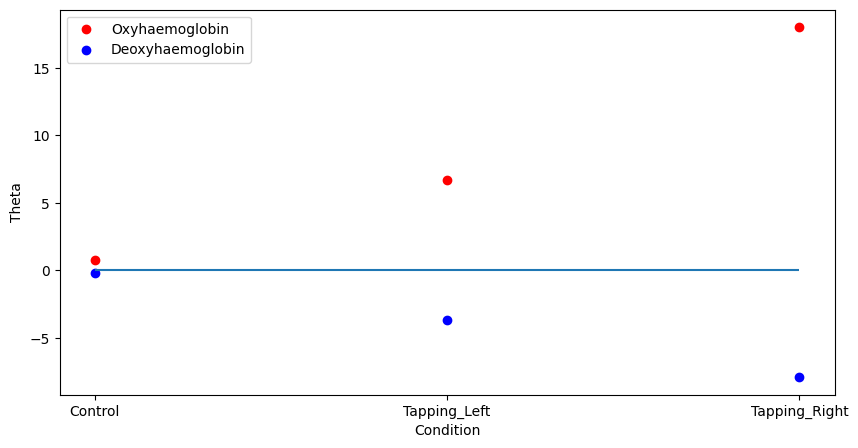

In [70]:
glm_est.scatter()
#glm_est.plot_topo(conditions=["Tapping_Left", "Tapping_Right"])

## Fit GLM to all data and view topographic distribution

Lastly we can run the GLM analysis on all sensors and plot the result on a
topomap.
We see the same result as in the MNE tutorial,
that activation is largest
contralateral to the tapping side. Also note that HbR tends to be the
negative of HbO as expected.



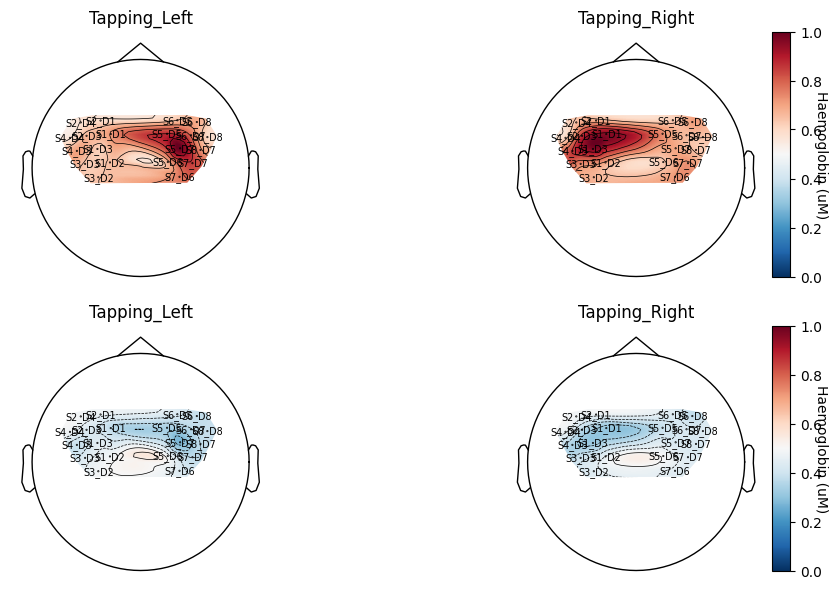

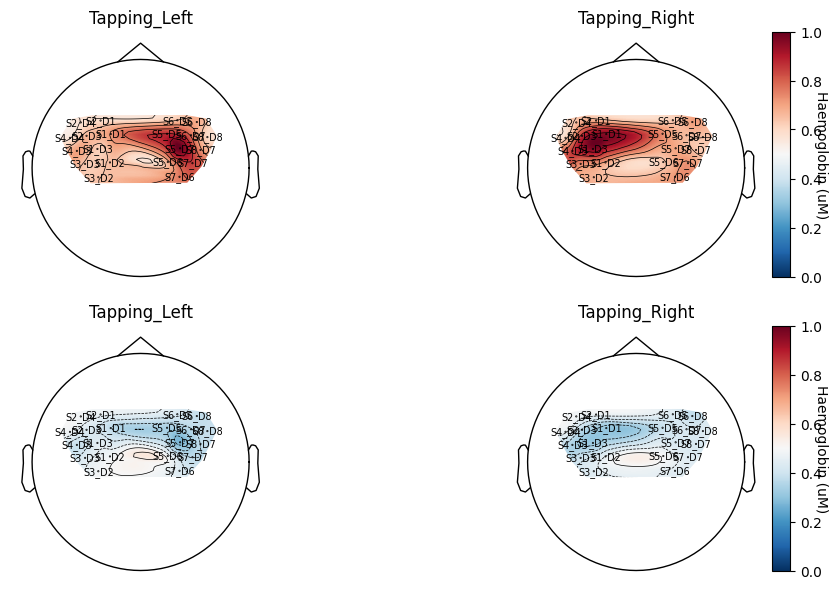

In [92]:
glm_est = run_glm(raw_haemo, design_matrix)
glm_est.plot_topo(conditions=["Tapping_Left", "Tapping_Right"])

Note that the topographic visualisation is a high level representation
of the underlying data. This visual representation fits a smoothed surface
to the data and makes many assumptions including that the data is
spatially smooth and that the sensors sufficiently cover the scalp surface.
These assumptions can be violated with fNIRS due to the improved spatial
sensitivity (relative to EEG) and typically low number of sensors that are
unevenly distributed over the scalp.
As such, researchers should understand the underlying data and ensure that
the figure accurately reflects the effect of interest.

As an example of how the topoplot can be deceiving, we replot
the `Tapping/Right` condition from above for each hemisphere
separately. When both hemisphere are plotted together (left),
the function smooths
the large space between sensors, making the activity on the left hemisphere
smear towards the center and appear larger than the underlying data shows.
When each hemisphere is plotted independently (right) it becomes immediately
apparent that the data does not indicate that activity spreads across
the center of the head.



['S1_D1 hbo', 'S1_D2 hbo', 'S1_D3 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S2_D4 hbo', 'S3_D2 hbo', 'S3_D3 hbo', 'S4_D3 hbo', 'S4_D4 hbo', 'S5_D5 hbo', 'S5_D6 hbo', 'S5_D7 hbo', 'S6_D5 hbo', 'S6_D7 hbo', 'S6_D8 hbo', 'S7_D6 hbo', 'S7_D7 hbo', 'S8_D7 hbo', 'S8_D8 hbo']


Text(0.5, 1.0, 'Hemispheres plotted independently')

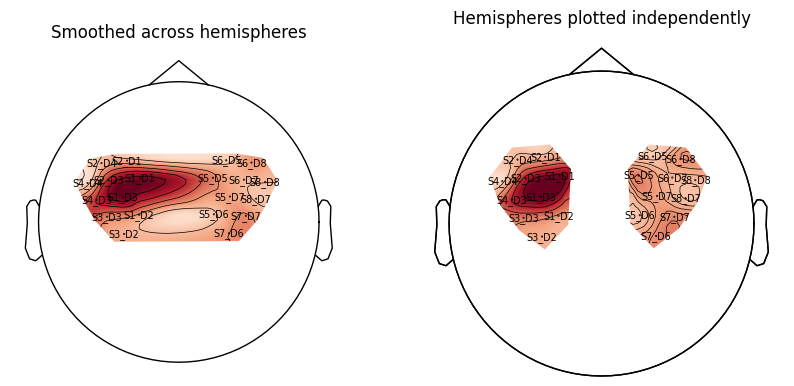

In [76]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 6), gridspec_kw=dict(width_ratios=[0.92, 1])
)

glm_hbo = glm_est.copy().pick(picks="hbo")
print(glm_hbo.ch_names)
conditions = ["Tapping_Right"]

glm_hbo.plot_topo(axes=axes[0], colorbar=False, conditions=conditions)

glm_hbo.copy().pick(picks=range(10)).plot_topo(
    conditions=conditions, axes=axes[1], colorbar=False, vlim=(-16, 16)
)
glm_hbo.copy().pick(picks=range(10, 20)).plot_topo(
    conditions=conditions, axes=axes[1], colorbar=False, vlim=(-16, 16)
)

axes[0].set_title("Smoothed across hemispheres")
axes[1].set_title("Hemispheres plotted independently")

Another way to view the data is to project the GLM estimates to the nearest
cortical surface



In [86]:
os.environ["SUBJECTS_DIR"] = r"C:\Users\bede\mne_data\MNE-sample-data\subjects"
glm_est.copy().surface_projection(
    condition="Tapping_Right", view="dorsal", chroma="hbo"
)

False


## Analyse regions of interest

.. sidebar:: Relevant literature

   Zimeo Morais, G.A., Balardin, J.B. & Sato, J.R.
   fNIRS Optodes’ Location Decider (fOLD): a toolbox for probe arrangement
   guided by brain regions-of-interest. Sci Rep 8, 3341 (2018).

   Shader and Luke et al. "The use of broad vs restricted regions of
   interest in functional near-infrared spectroscopy for measuring cortical
   activation to auditory-only and visual-only speech."
   Hearing Research (2021): [108256](https://www.sciencedirect.com/science/article/pii/S0378595521000903).

Or alternatively we can summarise the responses across regions of interest
for each condition. And you can plot it with your favorite software.
Region of interest analysis can be more robust than single channel analysis.
The fOLD toolbox can be used to assist in the design of ROIs.
And consideration should be paid to ensure optimal size ROIs are selected.



In [90]:
left = [[1, 1], [1, 2], [1, 3], [2, 1], [2, 3], [2, 4], [3, 2], [3, 3], [4, 3], [4, 4]]
right = [[5, 5], [5, 6], [5, 7], [6, 5], [6, 7], [6, 8], [7, 6], [7, 7], [8, 7], [8, 8]]

groups = dict(
    Left_ROI=picks_pair_to_idx(raw_haemo, left),
    Right_ROI=picks_pair_to_idx(raw_haemo, right),
)

conditions = ["Control", "Tapping_Left", "Tapping_Right"]

df = glm_est.to_dataframe_region_of_interest(groups, conditions)

As with the single channel results above, this is placed in a tidy dataframe
which contains conveniently extracted information, but now for the region
of interest.



In [88]:
df

,ROI,Condition,Chroma,theta,se,t,dfe,p,Weighted
0,Left_ROI,Control,hbo,-1.690850e-07,0.906548,-0.186515,35,8.531176e-01,Inverse standard error
1,Left_ROI,Control,hbr,1.621215e-07,0.510929,0.317307,35,7.528959e-01,Inverse standard error
2,Right_ROI,Control,hbo,3.814778e-08,0.941335,0.040525,35,9.679047e-01,Inverse standard error
3,Right_ROI,Control,hbr,-1.034544e-07,0.532735,-0.194195,35,8.471461e-01,Inverse standard error
0,Left_ROI,Tapping_Left,hbo,4.808888e-06,0.919870,5.227791,35,8.051619e-06,Inverse standard error
1,Left_ROI,Tapping_Left,hbr,-1.837941e-06,0.518407,-3.545361,35,1.136272e-03,Inverse standard error
2,Right_ROI,Tapping_Left,hbo,9.219006e-06,0.955125,9.652143,35,2.123476e-11,Inverse standard error
3,Right_ROI,Tapping_Left,hbr,-3.877839e-06,0.540531,-7.174123,35,2.280434e-08,Inverse standard error
0,Left_ROI,Tapping_Right,hbo,9.738244e-06,0.922471,10.556691,35,2.015806e-12,Inverse standard error
1,Left_ROI,Tapping_Right,hbr,-3.240867e-06,0.519857,-6.234145,35,3.799977e-07,Inverse standard error


## Compute contrasts

We can also define a contrast as described in
[Nilearn docs](http://nilearn.github.io/auto_examples/04_glm_first_level/plot_localizer_surface_analysis.html)_
and plot it.
Here we contrast the response to tapping on the left hand with the response
from tapping on the right hand.



IndexError: invalid index to scalar variable.

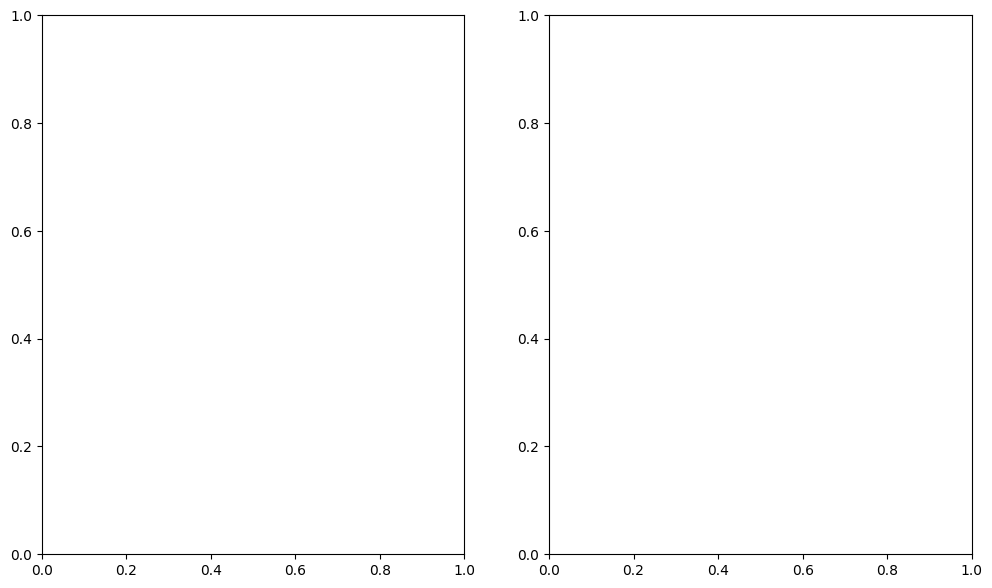

In [94]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_conts = dict(
    [(column, contrast_matrix[i]) for i, column in enumerate(design_matrix.columns)]
)
contrast_LvR = basic_conts["Tapping_Left"] - basic_conts["Tapping_Right"]

contrast = glm_est.compute_contrast(contrast_LvR)
contrast.plot_topo()

## Export Results

.. sidebar:: Relevant literature

   Wickham, Hadley. "Tidy data." Journal of Statistical Software 59.10 (2014): 1-23.

Here we export the data in a tidy pandas data frame.
We export the GLM results for every channel and condition.
Data is exported in long format by default.
However, a helper function is also provided to convert the long data to wide format.
The long to wide conversion also adds some additional derived data, such as
if a significant response (p<0.05) was observed, which sensor and detector is
in the channel, which chroma, etc.



In [ ]:
df = glm_est.to_dataframe() # saves GLM results for every channel and condition in design matrix (n_channels x n_regressors x n_chroma)

## Determine true and false positive rates

We can query the exported data frames to determine the true and false
positive rates. Note: optodes cover a greater region than just the
motor cortex, so we dont expect 100% of channels to detect responses to
the tapping, but we do expect 5% or less for the false positive rate.



In [99]:
(
    df.query('Condition in ["Control", "Tapping_Left", "Tapping_Right"]')
    .drop(["df", "mse", "p_value", "t"], axis=1)
    .groupby(["Condition", "Chroma", "ch_name"])
    .agg(["mean"])
)

variable                                  se         theta Source Detector  \
                                        mean          mean   mean     mean   
Condition     Chroma ch_name                                                 
Control       hbo    S1_D1 hbo  1.066677e-06  7.767152e-07    1.0      1.0   
                     S1_D2 hbo  7.491500e-07 -4.497856e-08    1.0      2.0   
                     S1_D3 hbo  7.672949e-07  4.646158e-07    1.0      3.0   
                     S2_D1 hbo  6.342857e-07 -5.627240e-07    2.0      1.0   
                     S2_D3 hbo  8.390797e-07  8.605292e-07    2.0      3.0   
...                                      ...           ...    ...      ...   
Tapping_Right hbr    S6_D8 hbr  7.334896e-07 -4.239772e-06    6.0      8.0   
                     S7_D6 hbr  6.292325e-07 -1.893321e-06    7.0      6.0   
                     S7_D7 hbr  4.903269e-07 -2.039497e-06    7.0      7.0   
                     S8_D7 hbr  6.149382e-07 -2.704977e-06    8.0      7.0   
                     S8_D8 hbr  1.203101e-06 -2.265968e-06    8.0      8.0   

variable                       Significant  
                                      mean  
Condition     Chroma ch_name                
Control       hbo    S1_D1 hbo         0.0  
                     S1_D2 hbo         0.0  
                     S1_D3 hbo         0.0  
                     S2_D1 hbo         0.0  
                     S2_D3 hbo         0.0  
...                                    ...  
Tapping_Right hbr    S6_D8 hbr         1.0  
                     S7_D6 hbr         1.0  
                     S7_D7 hbr         1.0  
                     S8_D7 hbr         1.0  
                     S8_D8 hbr         0.0  

[120 rows x 5 columns]